In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [4]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph3_ctrl_visiumHD_subsampled.h5ad')
adata

AnnData object with n_obs × n_vars = 10000 × 2707
    obs: 'cell_type', 'leiden', 'cell_type_int', 'sample'
    uns: 'cell_thresholds', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

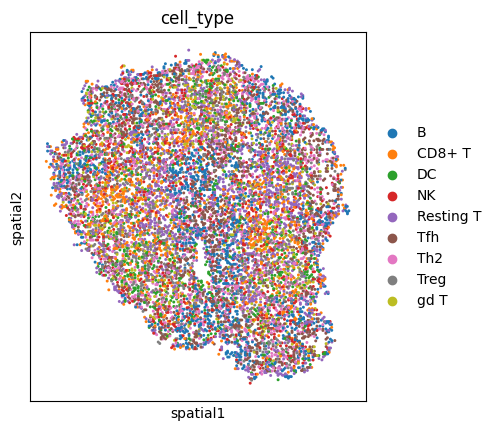

cell_type
Resting T    1479
Tfh          1423
B            1307
Th2          1209
Treg         1143
CD8+ T       1032
NK            949
DC            793
gd T          665
Name: count, dtype: int64

In [5]:
sc.pl.spatial(adata, color='cell_type', spot_size=20)
adata.obs['cell_type'].value_counts()

In [6]:
import sys
sys.path.append('../../src/')

In [7]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

In [9]:
adata

AnnData object with n_obs × n_vars = 10000 × 2707
    obs: 'cell_type', 'leiden', 'cell_type_int', 'sample'
    uns: 'cell_thresholds', 'received_ligands', 'received_ligands_tfl', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

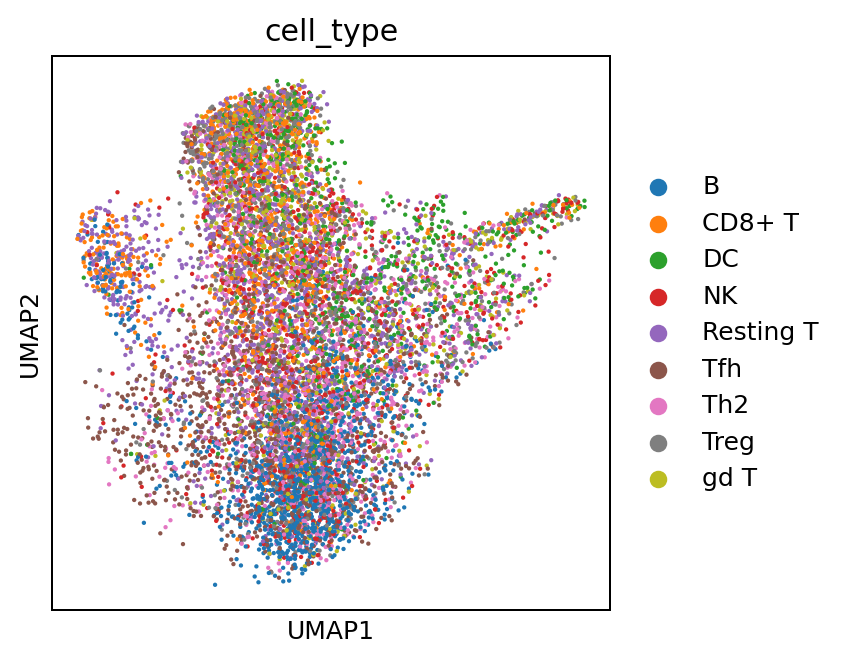

In [ ]:
sc.pl.umap(adata, color='cell_type')

In [13]:
%matplotlib inline

oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

In [14]:
base_GRN = co.data.load_mouse_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2


In [15]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=5,
    verbose_level=1
)

100%|██████████| 9/9 [26:32<00:00, 176.97s/it]

CPU times: user 21min 4s, sys: 3.57 s, total: 21min 8s
Wall time: 26min 32s


In [16]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=5, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/9 [00:00<?, ?it/s]

In [17]:
import pickle

with open('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph3_ctrl_visiumHD_subsampled_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [18]:
links.to_hdf5(file_path="/ix/djishnu/shared/djishnu_kor11/co_objects/mouse_lymph3_ctrl_visiumHD_subsampled.celloracle.links")
oracle.to_hdf5("/ix/djishnu/shared/djishnu_kor11/co_objects/mouse_lymph3_ctrl_visiumHD_subsampled.celloracle.oracle")